**목적**
- 이전 분석에서 회원의 행동이 이용 빈도 등에 따라 경향이 크게 달라짐을 확인함 
    - 클러스터링을 통해 그룹별 특징 파악
- 각 그룹의 행동 패턴을 파악하며, 고객별 이용 횟수 예측

**정보**
- 3장에서 가공된 data 사용
- 데이터 설명
    1. use_log.csv
        - 스포츠 센터 이용 이력 데이터 (201804~201903)
    2. customer_join.csv
        - 3장에서 정제한 이용 이력을 포함한 고객 데이터

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 폰트
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프 마이너스 폰트 깨지는 문제 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# Data Load

In [2]:
uselog = pd.read_csv('data_code/4장/use_log.csv')
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [3]:
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [4]:
customer = pd.read_csv('data_code/4장/customer_join.csv')
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [5]:
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

# 회원 Clustering
- 이용 이력을 이용해서 그룹화 진행 (탈퇴 여부로 분류 X)
- 정답이 없기 때문에 비지도학습 클러스터링 이용

## 변수 선택

In [6]:
# 고객 한 달 이용 이력, 회원 기간 변수 이용
customer_clustering = customer[['mean','median','max','min','membership_period']].copy()
customer_clustering

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47
...,...,...,...,...,...
4187,8.000000,8.0,8,8,1
4188,10.000000,10.0,10,10,1
4189,8.000000,8.0,8,8,1
4190,11.000000,11.0,11,11,1


## K-means
- 변수 간의 거리를 기반으로 클러스터링하는 알고리즘
- 그룹 수 미리 지정
- 이용 데이터 간의 scale 차이가 크기 때문에 표준화 진행한 후 그룹화 진행
    - mean ~ min 변수: 1 ~ 8 사이 값
    - membership_period: 최댓값이 47   -> 해당 변수에 의해 결과 좌지우지될 수도 있음 (표준화 미진행 시)

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_scaled = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)   # 군집수 4개
clusters = kmeans.fit(customer_scaled)
customer_clustering['cluster'] = clusters.labels_
customer_clustering['cluster'].unique()

array([3, 1, 0, 2])

In [8]:
customer_clustering.head()

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


## Clustering 결과 분석 및 시각화

In [9]:
# columns 이름 변경 (혼선 우려)
customer_clustering.columns = ['월평균값','월중앙값','월최댓값','월최솟값','회원기간','cluster']
customer_clustering.head(2)

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3


In [10]:
# 그룹별 수
customer_clustering['cluster'].value_counts().sort_index()

0    1336
1     761
2     846
3    1249
Name: cluster, dtype: int64

- 그룹 0과 3이 가장 많고, 그 다음으로 그룹 2, 그룹1 순서

In [11]:
# 그룹별 평균 파악
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


- 그룹 2와 1은 비교적 회원기간이 짧음
    - 그룹 2는 이용률이 가장 높고
    - 그룹 1은 이용률이 가장 낮음
- 그룹 0과 3은 비교적 회원기간이 김
    - 그룹 3은 그룹 0에 비해 회원기간이 더 길지만, 이용률이 약간 낮음

In [12]:
# 클러스터링 결과 시각화
# 5개 변수 -> 2개 변수로 축소 (차원축소 - 주성분분석 활용)
from sklearn.decomposition import PCA

X = customer_scaled    # scaling된 data

pca = PCA(n_components=2)  # 2차원으로 축소
pca.fit(X)
x_pca = pca.transform(X)     # 2개 축
pca_df = pd.DataFrame(x_pca)    
pca_df['cluster'] = customer_clustering['cluster']   # cluster column 추가
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,3
1,-0.707922,-1.799857,3
2,-1.061499,-1.659826,3
3,-1.160764,-1.810139,3
4,-2.017132,-1.670101,3


In [13]:
pca_df.columns = ['pca_0','pca_1','cluster']

Text(0, 0.5, '주성분')

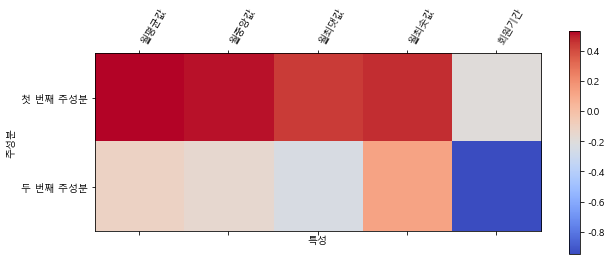

In [14]:
# 2개축 어떤 변수로 구성되었는지 파악
# components_값 heatmap 시각화
plt.matshow(pca.components_, cmap='coolwarm')
plt.yticks([0,1], ['첫 번째 주성분','두 번째 주성분'])
plt.colorbar()
plt.xticks(range(len(customer_clustering.columns[:5])), customer_clustering.columns[:5], rotation=60, ha='left')  # clustering column X
plt.xlabel('특성')
plt.ylabel('주성분')

- 첫번째 주성분은 월 기초통계량 값들이 주로 반영됨
    - 부호가 거의 같음 (특성 사이에 공통의 상호관계가 있음 - 한 특성의 값이 커지면, 다른 값들도 같이 높아짐)
- 두번째 주성분은 회원기간 변수가 많이 반영된 것으로 보임

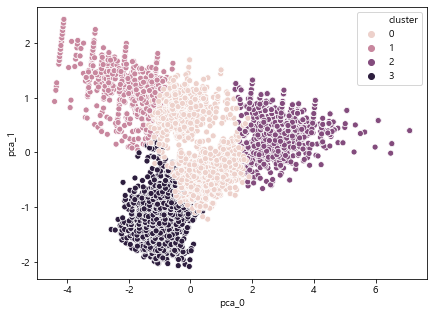

In [15]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x='pca_0', y='pca_1', hue='cluster')
plt.show()

- 군집별로 잘 나뉘어있는 것으로 확인됨 (pca로 정보를 보존한 채 깔끔하게 축소된 듯)

# Cluster 기반 탈퇴 회원 경향 파악

In [16]:
# is_deleted column 있는 customer data
customer.shape, customer_clustering.shape

((4192, 18), (4192, 6))

In [17]:
# concat(is_deleted column)
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.isnull().sum()

월평균값                    0
월중앙값                    0
월최댓값                    0
월최솟값                    0
회원기간                    0
cluster                 0
customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## 그룹별 탈퇴/지속 count

In [18]:
customer_clustering.groupby(['cluster','is_deleted'])[['customer_id']].count().reset_index()

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


- 그룹 1에 탈퇴 회원만 있음
- 그룹 0에 지속회원 비중이 좀 더 높긴 하지만, 탈퇴 회원도 다수 포함됨
- 그룹 2, 3은 지속회원 비중이 매우 높음
    - 이전 그룹별 월 이용 횟수 평균 지표도 같이 고려했을 때
    - 그룹 2는 회원기간이 짧기만, 초기에 의욕적이어서 전체적으로 이용률이 높음 -> 짧고 굵게
    - 그룹 3은 이용률이 그룹 2보다 낮지만, 회원기간이 가장 길고 지속회원이 많음 -> 안정적

## 그룹별 정기적/비정기적 이용 count

In [19]:
customer_clustering.groupby(['cluster','routine_flg'])[['customer_id']].count().reset_index()

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


In [20]:
496 / (496+265)

0.6517739816031537

- 지속회원 비중이 많았던 그룹 2,3 그리고 그룹 0에는 정기적으로 이용하는 회원이 다수임
    - 3장에서 확인한 특징과도 일치, 도메인 적으로도 이해 가능
- 탈퇴회원만 있었던 그룹 1은 비정기적 이용률이 65%로 절반 이상 차지함